<a href="https://colab.research.google.com/github/AkramKadoura/NLP-tensorflow/blob/main/medical_paper_abstracts_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Medical Paper Abstracts Sentence Classification 👨‍💻📋
NLP Model to make reading medical paper abstract easier. 
Replication of the paper: https://arxiv.org/pdf/1612.05251.pdf


In [ ]:
!nvidia-smi

Fri Aug  6 00:20:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get the dataset from author's github
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
# Data Preprocessing

def get_lines(filename):
  """
  Takes filename as an input and returns a list of the file lines.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
test_lines = get_lines(data_dir+"test.txt")
test_lines[:5]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n']

In [ ]:
def preprocess_text_lines(filename):
  """
  Returns a list of dictionaries of abstract data lines.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines= ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line
  
  return abstract_samples


In [ ]:
train_samples = preprocess_text_lines(data_dir+"train.txt")
val_samples = preprocess_text_lines(data_dir+"dev.txt")
test_samples = preprocess_text_lines(data_dir+"test.txt")

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

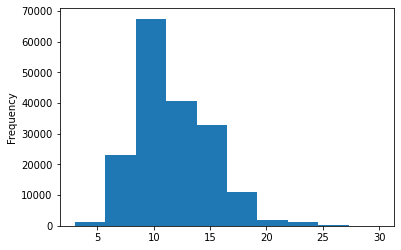

In [ ]:
import matplotlib.pyplot as plt

train_df.total_lines.plot.hist()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())


In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

###Baseline Model: TF-IDF Multinomial Naive Bayes classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-06 00:20:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-06 00:20:31 (93.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

baseline_preds = model_0.predict(val_sentences)
calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sentence_len = [len(sentence.split()) for sentence in train_sentences]
sentence_avg = np.mean(sentence_len)
sentence_avg

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

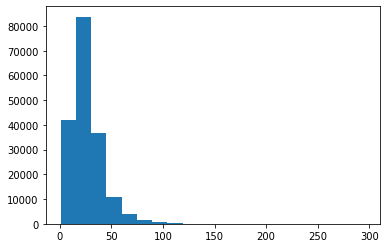

In [ ]:
plt.hist(sentence_len, bins=20)

In [ ]:
output_seq_len = int(np.percentile(sentence_len, 95))
max_tokens = 68000
output_seq_len

55

In [ ]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = output_seq_len,
    pad_to_max_tokens = True
)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
rct_20k_length_vocab = len(text_vectorizer.get_vocabulary())
rct_20k_length_vocab

64841

In [ ]:
token_embedding = layers.Embedding(
    input_dim = rct_20k_length_vocab,
    output_dim = 128,
    mask_zero=True,
    name="token_embedding")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

###Model 1: Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [ ]:
model_1.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=10,
            validation_data=val_dataset,
            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/10
562/562 [==============================] - 78s 83ms/step - loss: 0.9099 - accuracy: 0.6406 - val_loss: 0.6828 - val_accuracy: 0.7424
Epoch 2/10
562/562 [==============================] - 46s 83ms/step - loss: 0.6583 - accuracy: 0.7544 - val_loss: 0.6279 - val_accuracy: 0.7726
Epoch 3/10
562/562 [==============================] - 46s 82ms/step - loss: 0.6164 - accuracy: 0.7732 - val_loss: 0.5932 - val_accuracy: 0.7859
Epoch 4/10
562/562 [==============================] - 46s 82ms/step - loss: 0.5876 - accuracy: 0.7882 - val_loss: 0.5750 - val_accuracy: 0.7896
Epoch 5/10
562/562 [==============================] - 45s 81ms/step - loss: 0.5896 - accuracy: 0.7923 - val_loss: 0.5577 - val_accuracy: 0.7982
Epoch 6/10
562/562 [==============================] - 46s 82ms/step - loss: 0.5796 - accuracy: 0.7914 - val_loss: 0.5566 - val_accuracy: 0.7989
Epoch 7/10
562/562 [==============================] - 46s 82ms/step - loss: 0.5574 - accuracy: 0.8002 - val_loss: 0.5420 - val_accuracy:

In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5246 - accuracy: 0.8125


[0.5246255397796631, 0.8125247955322266]

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[5.7179642e-01, 9.5454961e-02, 8.6918235e-02, 2.0082892e-01,
        4.5001473e-02],
       [5.0469398e-01, 2.3665072e-01, 9.0620639e-03, 2.2512014e-01,
        2.4473045e-02],
       [1.3838147e-01, 3.9287549e-03, 8.9780096e-04, 8.5674983e-01,
        4.2034404e-05],
       ...,
       [6.3109328e-06, 2.3149415e-04, 2.6819485e-03, 7.9825313e-06,
        9.9707222e-01],
       [9.7457394e-02, 4.9465886e-01, 1.4265130e-01, 6.6027343e-02,
        1.9920512e-01],
       [2.9228536e-02, 9.5235968e-01, 1.2841697e-02, 1.2212555e-03,
        4.3487563e-03]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=model_1_preds,
                                    y_pred=val_labels_encoded)
model_1_results

{'accuracy': 81.25248245730174,
 'f1': 0.8157257290656176,
 'precision': 0.8209954095777399,
 'recall': 0.8125248245730173}

###Model 2: Feature Extraction with TF Hub pretrained token embeddings (Universal Sentence Encoder)

In [ ]:
import tensorflow_hub as hub

tf_hub_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                   trainable=False,
                                   name="universal_sentence_encoder")

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = tf_hub_embedding(inputs)
x = layers.Dense(128, activation="relu")(token_embeddings)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=10,
            validation_data=val_dataset,
            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/10
562/562 [==============================] - 8s 12ms/step - loss: 0.9181 - accuracy: 0.6511 - val_loss: 0.7950 - val_accuracy: 0.6868
Epoch 2/10
562/562 [==============================] - 6s 11ms/step - loss: 0.7669 - accuracy: 0.7034 - val_loss: 0.7504 - val_accuracy: 0.7081
Epoch 3/10
562/562 [==============================] - 6s 11ms/step - loss: 0.7491 - accuracy: 0.7135 - val_loss: 0.7334 - val_accuracy: 0.7174
Epoch 4/10
562/562 [==============================] - 6s 11ms/step - loss: 0.7154 - accuracy: 0.7266 - val_loss: 0.7060 - val_accuracy: 0.7281
Epoch 5/10
562/562 [==============================] - 6s 11ms/step - loss: 0.7235 - accuracy: 0.7219 - val_loss: 0.6860 - val_accuracy: 0.7380
Epoch 6/10
562/562 [==============================] - 6s 11ms/step - loss: 0.7157 - accuracy: 0.7259 - val_loss: 0.6799 - val_accuracy: 0.7367
Epoch 7/10
562/562 [==============================] - 6s 12ms/step - loss: 0.6834 - accuracy: 0.7410 - val_loss: 0.6633 - val_accuracy: 0.7507

In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.6540 - accuracy: 0.7507


[0.6539539694786072, 0.7506619691848755]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[4.08803970e-01, 4.72639978e-01, 4.76223999e-04, 1.10092513e-01,
        7.98732042e-03],
       [3.59148145e-01, 5.67304254e-01, 1.60236633e-03, 7.11194277e-02,
        8.25712166e-04],
       [4.52477843e-01, 4.25128229e-02, 2.25155726e-02, 4.42514032e-01,
        3.99796963e-02],
       ...,
       [1.06138072e-03, 7.57473812e-04, 1.58733409e-02, 1.79734343e-04,
        9.82128024e-01],
       [6.58525992e-03, 5.99818937e-02, 2.05958158e-01, 1.80303503e-03,
        7.25671649e-01],
       [5.69286570e-02, 8.33732247e-01, 1.01516135e-01, 9.64775507e-04,
        6.85825804e-03]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.06619886137959,
 'f1': 0.7462018424927349,
 'precision': 0.7462317345760753,
 'recall': 0.7506619886137958}

###Model 3: Conv1D with character-level embeddings

In [ ]:
def split_chars(sentence):
  return " ".join(list(sentence))

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
sentence_char_len = [len(sentence) for sentence in train_sentences]
sentence_char_avg = np.mean(sentence_char_len)
sentence_char_avg

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

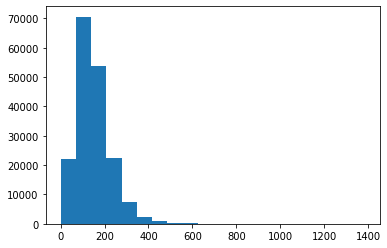

In [ ]:
plt.hist(sentence_char_len, bins=20)

In [ ]:
output_seq_char_len = int(np.percentile(sentence_char_len, 95))
output_seq_char_len

290

In [ ]:
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation
max_char_tokens = len(alphabets) + 2
max_char_tokens

70

In [ ]:
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
                  max_tokens=max_char_tokens,
                  output_sequence_length=output_seq_char_len, 
                  pad_to_max_tokens=True, 
                  name="char_vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
char_embedding = tf.keras.layers.Embedding(
                   input_dim=len(char_vocab), 
                   output_dim=25, 
                   mask_zero=True,
                   name="char_embedding")

In [ ]:
import random
char_embedding(char_vectorizer([random.choice(train_chars)]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 0.03478629, -0.04977624,  0.00292454, ..., -0.03235443,
         -0.00898726,  0.0047344 ],
        [-0.01528745, -0.00857556, -0.01811093, ..., -0.00418675,
          0.00223818,  0.04403022],
        [-0.01977626, -0.0340328 , -0.01893659, ..., -0.04481373,
          0.00700118, -0.04042305],
        ...,
        [-0.00171211, -0.03282445, -0.01847491, ...,  0.03533656,
         -0.04384211,  0.04447356],
        [-0.00171211, -0.03282445, -0.01847491, ...,  0.03533656,
         -0.04384211,  0.04447356],
        [-0.00171211, -0.03282445, -0.01847491, ...,  0.03533656,
         -0.04384211,  0.04447356]]], dtype=float32)>

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vector)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embedding (Embedding)   (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
model_3.fit(train_char_dataset,
            steps_per_epoch=int(0.1*len(train_char_dataset)),
            epochs=10,
            validation_data=val_char_dataset,
            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/10
562/562 [==============================] - 4s 6ms/step - loss: 1.2669 - accuracy: 0.4942 - val_loss: 1.0417 - val_accuracy: 0.5884
Epoch 2/10
562/562 [==============================] - 3s 6ms/step - loss: 0.9962 - accuracy: 0.6021 - val_loss: 0.9202 - val_accuracy: 0.6366
Epoch 3/10
562/562 [==============================] - 3s 6ms/step - loss: 0.9204 - accuracy: 0.6377 - val_loss: 0.8520 - val_accuracy: 0.6639
Epoch 4/10
562/562 [==============================] - 3s 6ms/step - loss: 0.8697 - accuracy: 0.6620 - val_loss: 0.8284 - val_accuracy: 0.6745
Epoch 5/10
562/562 [==============================] - 3s 6ms/step - loss: 0.8559 - accuracy: 0.6649 - val_loss: 0.8030 - val_accuracy: 0.6858
Epoch 6/10
562/562 [==============================] - 3s 6ms/step - loss: 0.8339 - accuracy: 0.6785 - val_loss: 0.7819 - val_accuracy: 0.6968
Epoch 7/10
562/562 [==============================] - 3s 6ms/step - loss: 0.8242 - accuracy: 0.6797 - val_loss: 0.7789 - val_accuracy: 0.6991
Epoch 

In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7620 - accuracy: 0.7101


[0.7619976997375488, 0.710148274898529]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)


model_3_results

{'accuracy': 71.01482854494903,
 'f1': 0.7050496755309736,
 'precision': 0.7040751559088542,
 'recall': 0.7101482854494903}

###Model 4: token-char embedding model (hybrid embedding)

In [ ]:
# token-inputs model
token_inputs_4 = layers.Input(shape=[], dtype=tf.string)
token_embeddings_4 = tf_hub_embedding(token_inputs_4)
token_output = layers.Dense(128, activation="relu")(token_embeddings_4)
token_model = tf.keras.Model(inputs=token_inputs_4, outputs=token_output)

# char-inputs model
char_inputs_4 = layers.Input(shape=(1,), dtype=tf.string)
char_vectors_4 = char_vectorizer(char_inputs_4)
char_embeddings_4 = char_embedding(char_vectors_4)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings_4)
char_model = tf.keras.Model(inputs=char_inputs_4, outputs=char_bi_lstm)

# token-char inputs concatenation model
token_char_concat = layers.Concatenate()([token_model.output, char_model.output])

concat_dropout = layers.Dropout(0.5)(token_char_concat)
concat_dense = layers.Dense(128, activation="relu")(concat_dropout)
output_dropout = layers.Dropout(0.5)(concat_dense)
output_4 = layers.Dense(5, activation="softmax")(output_dropout)

model_4 = tf.keras.Model(inputs=[token_inputs_4, char_inputs_4],
                         outputs=output_4,
                         name="model_4")


model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           input_5[0][0]                    
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   input_4[0][0]                    
____________________________________________________________________________________________

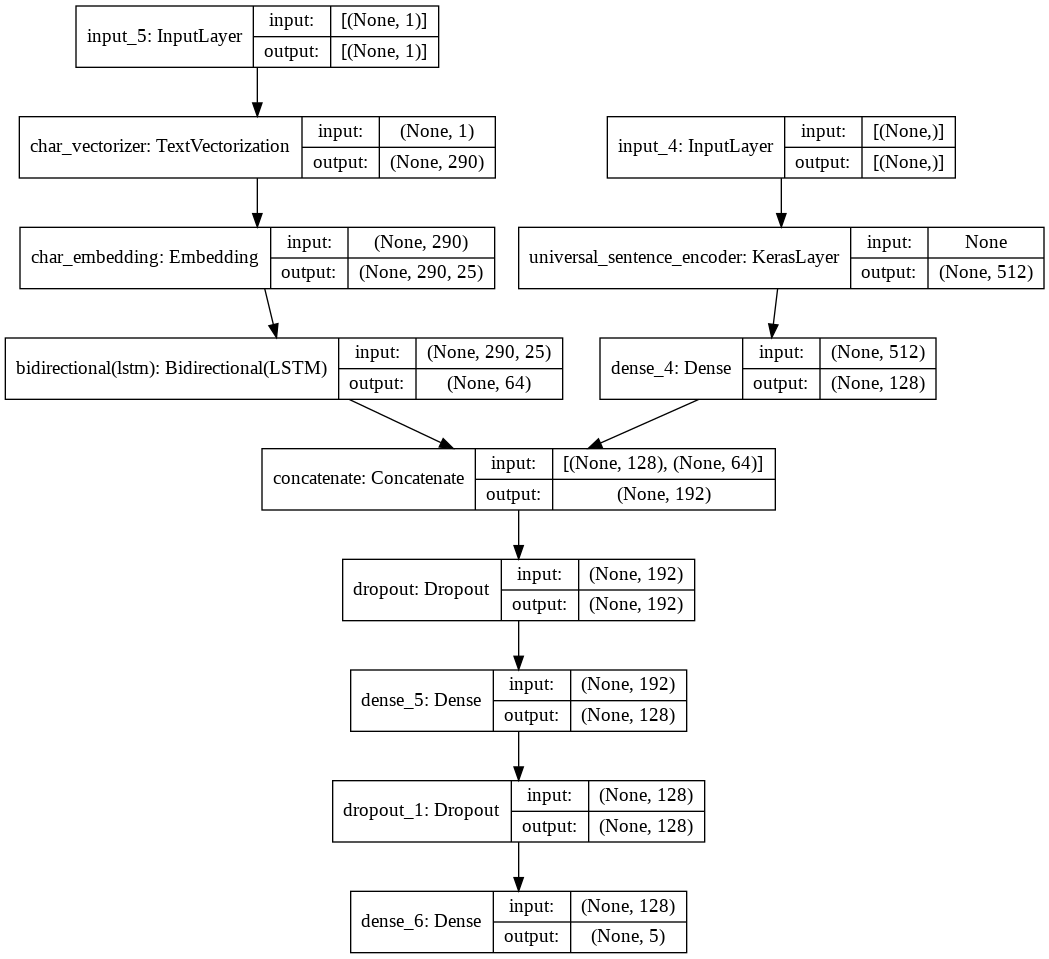

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_token_char_label = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_4.fit(train_token_char_dataset,
            steps_per_epoch=int(0.1*len(train_token_char_dataset)),
            epochs=10,
            validation_data=val_token_char_dataset,
            validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/10
562/562 [==============================] - 36s 49ms/step - loss: 0.9760 - accuracy: 0.6118 - val_loss: 0.7813 - val_accuracy: 0.7015
Epoch 2/10
562/562 [==============================] - 25s 44ms/step - loss: 0.7989 - accuracy: 0.6929 - val_loss: 0.7140 - val_accuracy: 0.7284
Epoch 3/10
562/562 [==============================] - 24s 43ms/step - loss: 0.7691 - accuracy: 0.7087 - val_loss: 0.6923 - val_accuracy: 0.7340
Epoch 4/10
562/562 [==============================] - 27s 49ms/step - loss: 0.7386 - accuracy: 0.7207 - val_loss: 0.6621 - val_accuracy: 0.7517
Epoch 5/10
562/562 [==============================] - 24s 43ms/step - loss: 0.7447 - accuracy: 0.7154 - val_loss: 0.6535 - val_accuracy: 0.7507
Epoch 6/10
562/562 [==============================] - 24s 43ms/step - loss: 0.7403 - accuracy: 0.7188 - val_loss: 0.6477 - val_accuracy: 0.7563
Epoch 7/10
562/562 [==============================] - 29s 51ms/step - loss: 0.7110 - accuracy: 0.7336 - val_loss: 0.6384 - val_accuracy:

In [ ]:
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)


model_4_results

{'accuracy': 76.28094796769496,
 'f1': 0.7578571981229492,
 'precision': 0.7596534273111337,
 'recall': 0.7628094796769496}

###Model 5: token embeddengs + character embeddengs + positional embeddings (tribrid model)

In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

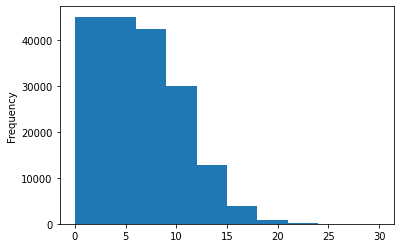

In [ ]:
train_df['line_number'].plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

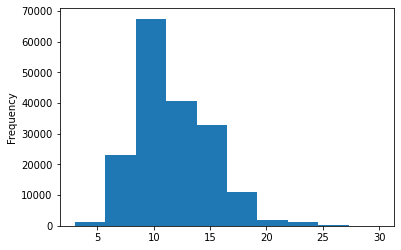

In [ ]:
train_df['total_lines'].plot.hist()

In [ ]:
coverage = np.percentile(train_df['total_lines'], 95)
coverage

18.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [ ]:
token_inputs_5 = layers.Input(shape=[], dtype=tf.string)
token_embeddings_5 = tf_hub_embedding(token_inputs_5)
token_output_5 = layers.Dense(128, activation="relu")(token_embeddings_5)
token_model_5 = tf.keras.Model(inputs=token_inputs_5, outputs=token_output_5)

char_inputs_5 = layers.Input(shape=(1,), dtype=tf.string)
char_vectors_5 = char_vectorizer(char_inputs_5)
char_embeddings_5 = char_embedding(char_vectors_5)
char_bi_lstm_5 = layers.Bidirectional(layers.LSTM(32))(char_embeddings_5)
char_model_5 = tf.keras.Model(inputs=char_inputs_5, outputs=char_bi_lstm_5)


line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32)
xl = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=xl)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32)
xt = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=xt)

hybrid_embeddings = layers.Concatenate()([token_model_5.output, char_model_5.output])
z = xt = layers.Dense(256, activation="relu")(hybrid_embeddings)
z = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate()([line_number_model.output, 
                                           total_lines_model.output, 
                                           z])

output_5 = layers.Dense(5, activation="softmax")(tribrid_embeddings)

model_5 = tf.keras.Model(inputs=[line_number_model.input, 
                                 total_lines_model.input,
                                 token_model_5.input,
                                 char_model_5.input],
                         outputs=output_5)

model_5.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           input_11[0][0]                   
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   input_10[0][0]                   
___________________________________________________________________________________________

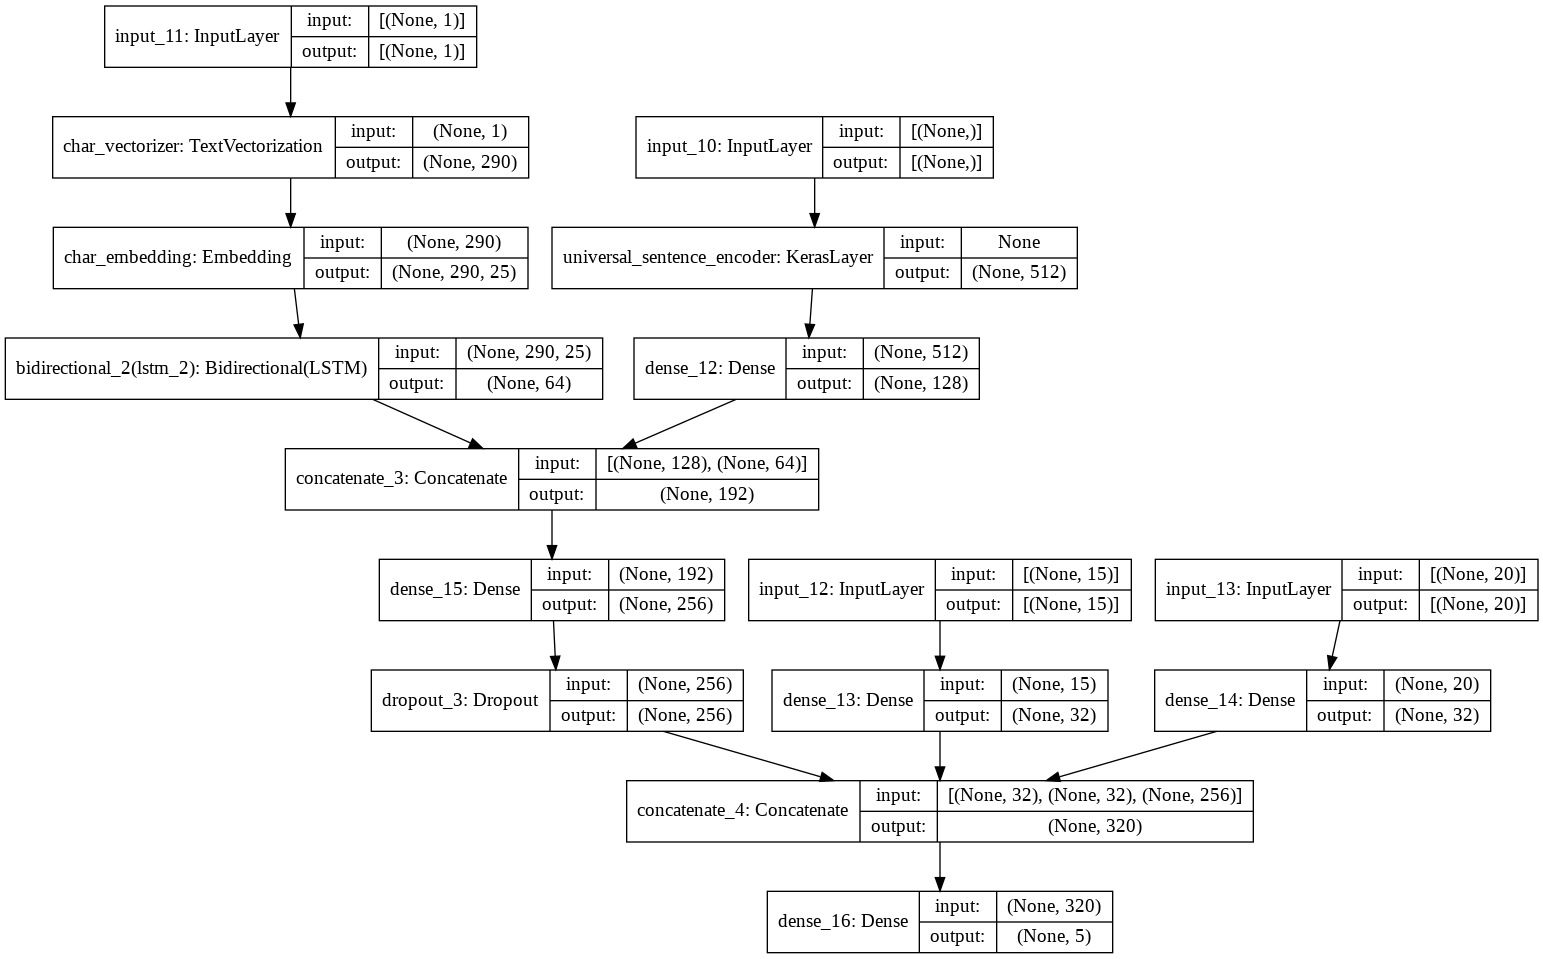

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])